In [1]:
import pandas as pd
import numpy as np
from time import process_time
from joblib import dump
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.ldamodel import LdaModel
from data_preprocessing import *
from model import *

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Embedding, Input, Dense, LSTM, Dropout, Flatten, Bidirectional, Conv1D, concatenate, SpatialDropout1D
from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalAveragePooling2D, GlobalAveragePooling1D 
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping

print(tf.__version__)

2.2.0


In [2]:
training_path = "../dataset/original-dataset/marathi-training-data.csv"
training_data = read_data(training_path)
training_data

,text,label
0,"प्रा . प्रताप हरिदास : होय , मला वाटते की हा ए...",com_tech
1,"तर , विशिष्ट गोष्टींद्वारे , ठराविक कायद्यांद्...",bioche
2,- - - - - - - - - - - - - - - - - - - - - - - ...,cse
3,"तर , आपला अर्धा चिन्ह 9 वाजता असेल .",phy
4,"म्हणून , मी असे म्हणालो की जर शेकडो , हजारो कि...",phy
...,...,...
41992,"जरी आपण डेटा कूटबद्ध केला , तरीही हा मुख्य व्य...",cse
41993,"ते म्हणतात - "" ज्याला पाहण्यासाठी डोळे , ऎकण्य...",com_tech
41994,"प्रथम क्रोनोलॉजिकल , क्रॉनोलॉजी म्हणजे आपल्याल...",com_tech
41995,"त्या थोड्या तपशीलावर येईल , जेणेकरून संपूर्ण ग...",bioche


In [3]:
val_path = "../dataset/original-dataset/marathi-validation-data.csv"
val_data = read_data(val_path)
val_data

,text,label
0,1 ची ओळ .,cse
1,"तर , ही एक टॉवर आहे जी टॉवरवर निश्चित केली जात...",phy
2,"तर , थ्रेडच्या परतीच्या स्थितीस पास करण्यासाठी...",cse
3,आपण लोक शोधत आहात जे आपल्यासाठी काहीतरी करू शक...,com_tech
4,लिनक्स कर्नल अनुसूचीतकरणामध्ये अशी तंत्र असण्य...,cse
...,...,...
3775,"नंतर वृद्धत्व , व्हॉट मोठ्या प्रमाणात फ्रॉन 12...",bioche
3776,आणि मग सुद्धा आपल्याला काही सेकंदांनंतर माहित ...,phy
3777,"तर , आपण ELF शीर्षलेखासह प्रारंभ करू .",cse
3778,"तर , त्या क्रॉस्टची जाडी आहे .",phy


In [4]:
x_train = training_data.text.apply(lambda x: clean_text(x)).values.tolist()
y_train = training_data.label.values.tolist()
x_val = val_data.text.apply(lambda x: clean_text(x)).values.tolist()
y_val = val_data.label.values.tolist()
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

41997
41997
3780
3780


In [5]:
y_train, y_val = label_encoder(y_train, y_val)

In [6]:
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)
print(y_train.shape)
print(y_val.shape)

(41997, 1)
(3780, 1)


In [7]:
pad_len=100
padding_type='post'
truncating_type='post'

In [8]:
corpus = []
for text in x_train:
    corpus.append(text)
print(len(corpus))
for text in x_val:
    corpus.append(text)
print(len(corpus))

41997
45777


In [9]:
tokenizer, x_train_tokenzied, x_val_tokenzied = tokenize_text(corpus, x_train, x_val)

In [10]:
x_train_padded, x_val_padded = pad_text(x_train_tokenzied, 
                                        x_val_tokenzied, 
                                        pad_len, 
                                        padding_type, 
                                        truncating_type)

In [ ]:
dump(tokenizer, "../tokenizers/DL-raw-tokenizer-100.pk1")

In [11]:
print(x_train_padded.shape)
print(x_val_padded.shape)

(41997, 100)
(3780, 100)


In [12]:
vocab = tokenizer.word_index
len(vocab.keys())

55100

# Domain Specific Fasttext Embeddings

In [13]:
start = process_time()
embedding_path1 = "/home/eastwind/word-embeddings/fasttext/TechDofication.mr.raw.complete.ft.skipgram.d300.vec"
embedding_matrix1 = get_embedding_matrix(embedding_path1, vocab, embedding_dim=300)
end = process_time()
print("Total time taken: ", end-start)
embedding_matrix1.shape

53723
Total time taken:  5.902595231000001


(55101, 300)

In [14]:
input_dim1 = embedding_matrix1.shape[0]
embedding_dim1 = 300
input_len = pad_len
print("Input dimension 1: ", input_dim1)
print("Embedding dimensions 1: ", embedding_dim1)
print("Input sentence dimensions 1: ", input_len)

Input dimension 1:  55101
Embedding dimensions 1:  300
Input sentence dimensions 1:  100


# Multi-channel BiLSTM-CNN Architecture with Attention

In [15]:
class AttentionLayer(Layer):
    
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        
        
    def build(self, attention_input):
        super(AttentionLayer, self).build(attention_input)
        lstm_shape, cnn_shape = attention_input
        # Attention Weights for LSTM
        self.W_in = self.add_weight(shape=(lstm_shape[-1], 1),
                                    initializer='glorot_normal',
                                    trainable=True,
                                    name='input_attention_weights')
        
        # Attention Weights for CNN
        self.W_context = self.add_weight(shape=(cnn_shape[-1], 1),
                                         initializer='glorot_normal',
                                         trainable=True,
                                         name='context_attention_weights')
                                      
        # Attention Bias
        self.b = self.add_weight(shape=(lstm_shape[1], 1),
                                 initializer='glorot_normal',
                                 trainable=True,
                                 name='attention_bias')
        
        
        
    def call(self, attention_input):
        lstm_output, cnn_output = attention_input
        et = K.squeeze(K.tanh(K.dot(lstm_output, self.W_in) + 
                              K.dot(cnn_output, self.W_context) +
                              self.b), axis=-1)
        at = K.expand_dims(K.softmax(et), axis=-1)
        attention_output = at * lstm_output
        attention_output = K.sum(attention_output, axis=1)
        return attention_output
    
    def get_config(self):
        return super(AttentionLayer, self).get_config()

In [16]:
Input1 = Input(shape=(input_len,))
Embedding_layer1 = Embedding(input_dim=input_dim1, 
                             output_dim=embedding_dim1, 
                             weights=[embedding_matrix1], 
                             trainable=False)(Input1)

# Input 1(BiLSTM):
Lstm = Bidirectional(LSTM(128, dropout=0.3, return_sequences=True))(Embedding_layer1)

# Input 2 (CNN):
Conv1 = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(Embedding_layer1)
Dropout1 = Dropout(0.3)(Conv1)
Conv2 = Conv1D(filters=256, kernel_size=4, activation='relu', padding='same')(Embedding_layer1)
Dropout2 = Dropout(0.3)(Conv2)
Conv3 = Conv1D(filters=256, kernel_size=5, activation='relu', padding='same')(Embedding_layer1)
Dropout3 = Dropout(0.3)(Conv3)
merged = concatenate([Dropout1, Dropout2, Dropout3], axis=1)
max_pool = MaxPooling1D(pool_size=3)(merged)

attention = AttentionLayer()([Lstm, max_pool])
Dense1 = Dense(64, activation='relu')(attention)
Dropout_dense = Dropout(0.25)(Dense1)
outputs = Dense(4, activation='softmax')(Dropout_dense)

classifier = Model(inputs=Input1, outputs=outputs)
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
classifier.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 300)     16530300    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 256)     230656      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 100, 256)     307456      embedding[0][0]                  
______________________________________________________________________________________________

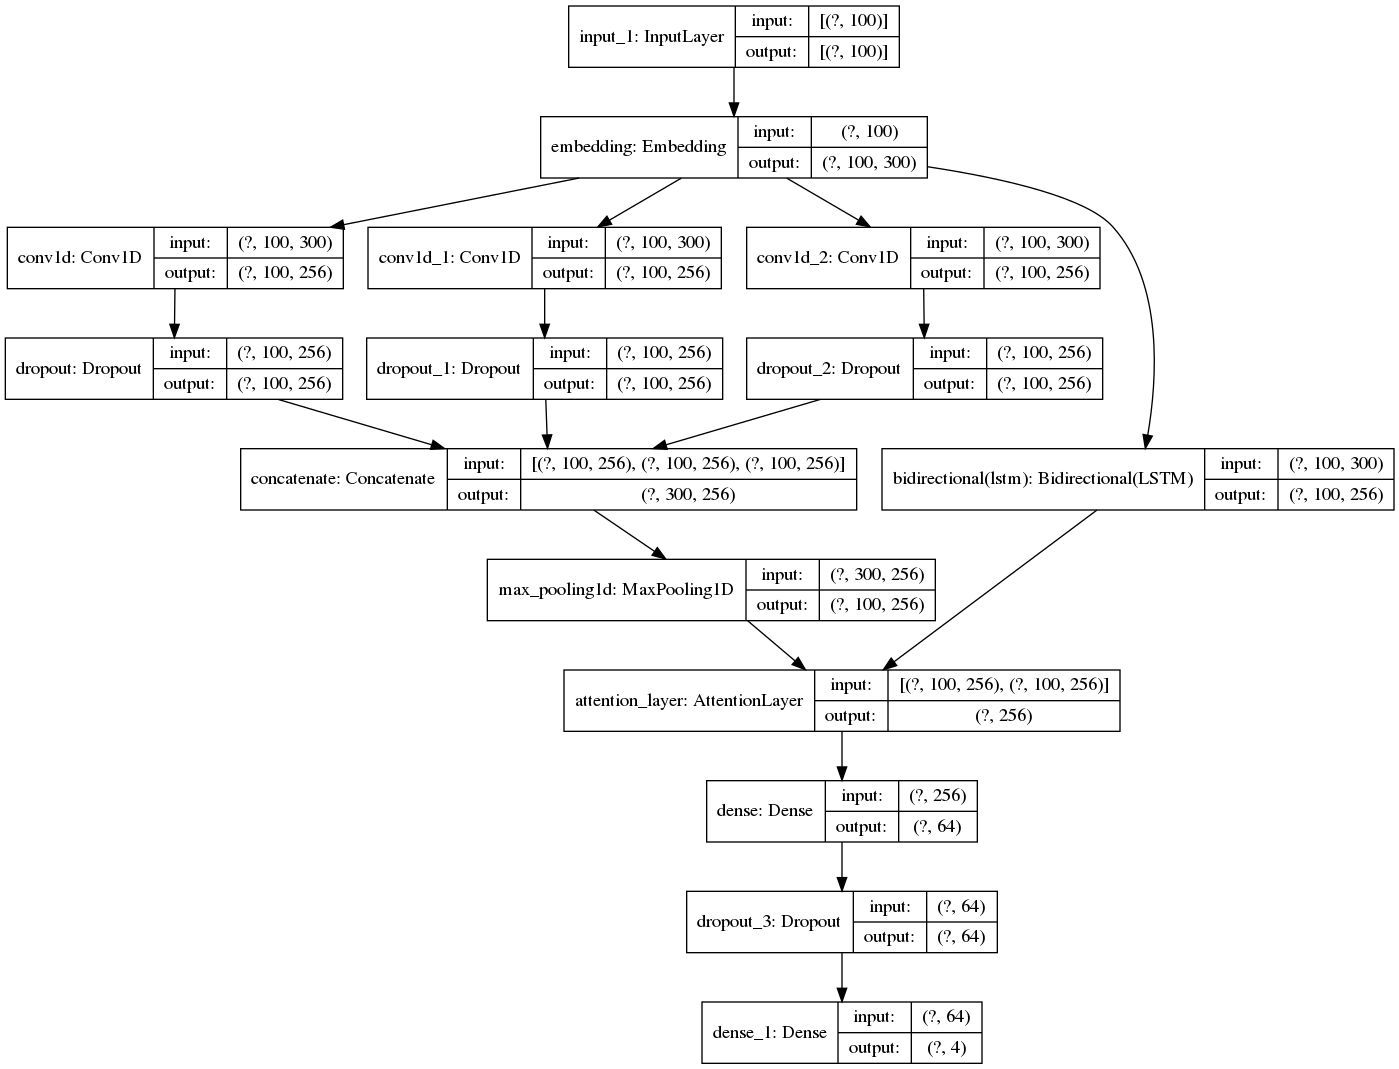

In [17]:
plot_model(classifier, show_shapes=True)

In [18]:
# ModelCheckPoint Callback:
checkpoint_filepath = "../models/multi-channel-LSTM-CNN/multi-channel-LSTM-CNN-epoch-{epoch:02d}-val-acc-{val_acc:02f}.h5"
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            save_weights_only=True,
                                            monitor='val_acc',
                                            mode='max',
                                            save_freq = 'epoch',
                                            save_best_only=True)

# Reduce Learning Rate on Plateau Callback:
reduce_lr_callback = ReduceLROnPlateau( monitor='val_acc', 
                                       factor=0.2, 
                                       patience=2, 
                                       min_lr=0.001, 
                                       verbose=2)
#myCB = myCallbacks(metrics='acc', threshold=0.97)

In [19]:
history = classifier.fit(x_train_padded, 
                         y_train, 
                         epochs=16,
                         batch_size=128,
                         verbose=1,
                         validation_data=(x_val_padded, y_val),
                         callbacks=[model_checkpoint_callback, reduce_lr_callback])

Epoch 1/16
329/329 [==============================] - 431s 1s/step - loss: 0.5450 - acc: 0.8006 - val_loss: 0.4373 - val_acc: 0.8511 - lr: 0.0010
Epoch 2/16
329/329 [==============================] - 609s 2s/step - loss: 0.4106 - acc: 0.8527 - val_loss: 0.3733 - val_acc: 0.8648 - lr: 0.0010
Epoch 3/16
329/329 [==============================] - 460s 1s/step - loss: 0.3778 - acc: 0.8628 - val_loss: 0.3421 - val_acc: 0.8767 - lr: 0.0010
Epoch 4/16
329/329 [==============================] - 455s 1s/step - loss: 0.3457 - acc: 0.8738 - val_loss: 0.3486 - val_acc: 0.8693 - lr: 0.0010
Epoch 5/16
329/329 [==============================] - 498s 2s/step - loss: 0.3231 - acc: 0.8827 - val_loss: 0.3425 - val_acc: 0.8807 - lr: 0.0010
Epoch 6/16
329/329 [==============================] - 435s 1s/step - loss: 0.3005 - acc: 0.8909 - val_loss: 0.3138 - val_acc: 0.8876 - lr: 0.0010
Epoch 7/16
329/329 [==============================] - 430s 1s/step - loss: 0.2842 - acc: 0.8965 - val_loss: 0.3191 - val_acc

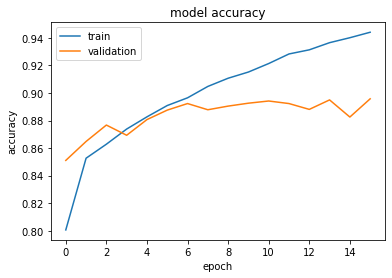

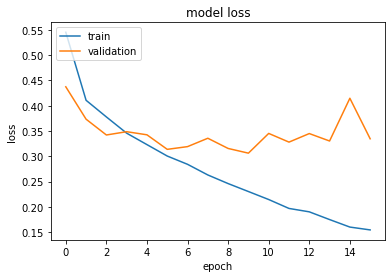

In [20]:
plot_curves(history)

In [24]:
classifier.load_weights("../models/multi-channel-LSTM-CNN/multi-channel-LSTM-CNN-epoch-10-val-acc-0.892593.h5")

In [23]:
results = np.argmax(classifier.predict(x_val_padded), axis=-1)
acc, precision, recall, f1 = classification_report(y_val, results)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.894973544973545

Precision:  [0.91598916 0.89439794 0.88888889 0.89357218]
Average Precision:  0.8982120423739728

Recall:  [0.8047619  0.92292359 0.91299435 0.8742268 ]
Average Recall:  0.8787266618019923

F1-Score:  [0.85678074 0.90843689 0.90078038 0.88379364]
Average F1-Score:  0.8874479108813199


# Old Results

In [33]:
history = classifier.fit(x_train_padded, 
                         y_train, 
                         epochs=16,
                         batch_size=128,
                         verbose=1,
                         validation_data=(x_val_padded, y_val),
                         callbacks=[checkpoint_filepath])

Epoch 1/30
329/329 [==============================] - 271s 823ms/step - loss: 0.5470 - acc: 0.7956 - val_loss: 0.4354 - val_acc: 0.8370
Epoch 2/30
329/329 [==============================] - 277s 842ms/step - loss: 0.3783 - acc: 0.8671 - val_loss: 0.3758 - val_acc: 0.8683
Epoch 3/30
329/329 [==============================] - 275s 837ms/step - loss: 0.3430 - acc: 0.8784 - val_loss: 0.3496 - val_acc: 0.8767
Epoch 4/30
329/329 [==============================] - 271s 823ms/step - loss: 0.3094 - acc: 0.8893 - val_loss: 0.3448 - val_acc: 0.8791
Epoch 5/30
329/329 [==============================] - 243s 738ms/step - loss: 0.2820 - acc: 0.8997 - val_loss: 0.3389 - val_acc: 0.8780
Epoch 6/30
329/329 [==============================] - 200s 609ms/step - loss: 0.2541 - acc: 0.9088 - val_loss: 0.3293 - val_acc: 0.8905
Epoch 7/30
329/329 [==============================] - 205s 623ms/step - loss: 0.2262 - acc: 0.9193 - val_loss: 0.3413 - val_acc: 0.8836
Epoch 8/30
329/329 [============================

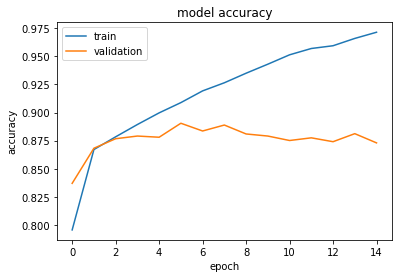

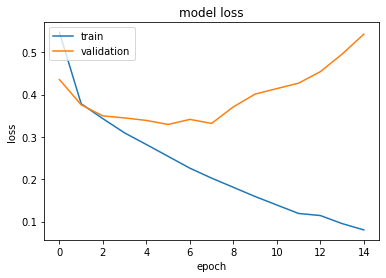

In [34]:
plot_curves(history)

In [35]:
results = np.argmax(classifier.predict(x_val_padded), axis=-1)
acc, precision, recall, f1 = classification_report(y_val, results)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.873015873015873

Precision:  [0.8688946  0.91832386 0.83299595 0.85025126]
Average Precision:  0.8676164182192978

Recall:  [0.8047619  0.85913621 0.9299435  0.87216495]
Average Recall:  0.8665016421662391

F1-Score:  [0.83559951 0.88774459 0.87880406 0.8610687 ]
Average F1-Score:  0.8658042146792221


In [37]:
save_model(classifier, "multi-channel-LSTM-CNN/BiLSTM-CNN-Attention-f1-8658")

Confusion matrix, without normalization


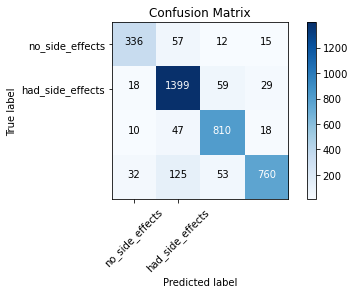

In [26]:
plot_confusion_matrix(y_val, 
                      results2, 
                      classes=['no_side_effects','had_side_effects'], 
                      title='Confusion Matrix',
                      normalize=False)